In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_resnet2'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds"

    # ============== model cfg =============
    model_name = 'resnet34d'

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 20
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-3
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.Downscale(p=0.25),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),

        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月24日 01:53:52


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import torch.nn.functional as F

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # xの次元数が4（バッチ、チャネル、高さ、幅）であることを確認
        if x.dim() != 4:
            raise ValueError(f'Expected 4D input (got {x.dim()}D input)')
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [17]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        self.n_features = self.model.num_features

        self.target_size = cfg.target_size if target_size is None else target_size

        # nn.Dropout(0.5),
        self.fc = nn.Sequential(
            nn.Linear(self.n_features, self.target_size)
        )

    def feature(self, image):

        feature = self.model(image)
        return feature

    def forward(self, image):
        feature = self.feature(image)
        output = self.fc(feature)
        return output

# scheduler

In [18]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [19]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [20]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [21]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    for df_score in list_df_score:
        ax1.plot(df_score['val_loss'])
        ax2.plot(df_score['val_score'])
    ax1.set_title('Validation Loss')
    ax2.set_title('Validation Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Score')
    ax1.set_ylim([0, 1.5])
    ax2.set_ylim([0, 1.5])
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========


pretrained: True


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 21m 4s) Loss: 6.0262(6.0262) Grad: 85801.1016  LR: 0.000100  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.4493(2.3491) Grad: 387529.8125  LR: 0.000100  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.5360(2.2752) Grad: 294086.5312  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 1.5865(1.5865) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2752  avg_val_loss: 1.7777  time: 78s
Epoch 1 - avg_train_Score: 2.2752 avgScore: 1.7777
Epoch 1 - Save Best Score: 1.7777 Model
Epoch 1 - Save Best Loss: 1.7777 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.6941(1.7777) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 15s) Loss: 1.3366(1.3366) Grad: 240240.2344  LR: 0.000100  
Epoch: [2][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.2177(1.2015) Grad: 127443.4453  LR: 0.000100  
Epoch: [2][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.3462(1.1963) Grad: 119637.0156  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 1.0776(1.0776) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1963  avg_val_loss: 1.0577  time: 76s
Epoch 2 - avg_train_Score: 1.1963 avgScore: 1.0577


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0533(1.0577) 


Epoch 2 - Save Best Score: 1.0577 Model
Epoch 2 - Save Best Loss: 1.0577 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 1.0540(1.0540) Grad: 224408.5469  LR: 0.001000  
Epoch: [3][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.1572(1.2658) Grad: 186599.6406  LR: 0.001000  
Epoch: [3][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.8374(1.2554) Grad: 162324.6250  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 1.1148(1.1148) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2554  avg_val_loss: 1.0079  time: 78s
Epoch 3 - avg_train_Score: 1.2554 avgScore: 1.0079
Epoch 3 - Save Best Score: 1.0079 Model
Epoch 3 - Save Best Loss: 1.0079 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0547(1.0079) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 1.3161(1.3161) Grad: 182807.8906  LR: 0.001000  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.2395(1.0632) Grad: 155879.5156  LR: 0.001000  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9494(1.0631) Grad: 154049.3125  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.9867(0.9867) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9651(0.9362) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0631  avg_val_loss: 0.9362  time: 78s
Epoch 4 - avg_train_Score: 1.0631 avgScore: 0.9362
Epoch 4 - Save Best Score: 0.9362 Model
Epoch 4 - Save Best Loss: 0.9362 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385

Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 54s) Loss: 1.0229(1.0229) Grad: 164060.0312  LR: 0.000958  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0868(0.9709) Grad: 136227.7031  LR: 0.000958  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9400(0.9710) Grad: 147903.8594  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.9907(0.9907) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9251(0.8963) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9710  avg_val_loss: 0.8963  time: 78s
Epoch 5 - avg_train_Score: 0.9710 avgScore: 0.8963
Epoch 5 - Save Best Score: 0.8963 Model
Epoch 5 - Save Best Loss: 0.8963 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385

Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 42s) Loss: 0.8419(0.8419) Grad: 166422.1250  LR: 0.000916  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8733(0.8951) Grad: 142547.5312  LR: 0.000916  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9062(0.8959) Grad: 132938.8906  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.9241(0.9241) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8959  avg_val_loss: 0.8529  time: 78s
Epoch 6 - avg_train_Score: 0.8959 avgScore: 0.8529
Epoch 6 - Save Best Score: 0.8529 Model
Epoch 6 - Save Best Loss: 0.8529 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8827(0.8529) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 20s) Loss: 0.6408(0.6408) Grad: 92948.2500  LR: 0.000865  
Epoch: [7][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.7907(0.8181) Grad: 139256.1250  LR: 0.000865  
Epoch: [7][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.7673(0.8180) Grad: 138324.8281  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8767(0.8767) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8180  avg_val_loss: 0.8144  time: 78s
Epoch 7 - avg_train_Score: 0.8180 avgScore: 0.8144
Epoch 7 - Save Best Score: 0.8144 Model
Epoch 7 - Save Best Loss: 0.8144 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8443(0.8144) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 39s) Loss: 0.8129(0.8129) Grad: 132884.2188  LR: 0.000805  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8151(0.7524) Grad: 131422.0312  LR: 0.000805  
Epoch: [8][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6157(0.7542) Grad: 102802.6094  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.7929(0.7929) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7542  avg_val_loss: 0.7821  time: 79s
Epoch 8 - avg_train_Score: 0.7542 avgScore: 0.7821


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7739(0.7821) 


Epoch 8 - Save Best Score: 0.7821 Model
Epoch 8 - Save Best Loss: 0.7821 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.5720(0.5720) Grad: 116953.7422  LR: 0.000738  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7570(0.6896) Grad: 131040.6328  LR: 0.000738  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6556(0.6892) Grad: 182708.1094  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7424(0.7424) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6892  avg_val_loss: 0.7523  time: 78s
Epoch 9 - avg_train_Score: 0.6892 avgScore: 0.7523


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7535(0.7523) 


Epoch 9 - Save Best Score: 0.7523 Model
Epoch 9 - Save Best Loss: 0.7523 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 13m 12s) Loss: 0.5527(0.5527) Grad: 102024.6562  LR: 0.000666  
Epoch: [10][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.5620(0.6177) Grad: 96161.3047  LR: 0.000666  
Epoch: [10][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6640(0.6184) Grad: 119099.7891  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 17s) Loss: 0.6903(0.6903) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6184  avg_val_loss: 0.7341  time: 78s
Epoch 10 - avg_train_Score: 0.6184 avgScore: 0.7341
Epoch 10 - Save Best Score: 0.7341 Model
Epoch 10 - Save Best Loss: 0.7341 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7727(0.7341) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.5090(0.5090) Grad: 103513.6562  LR: 0.000589  
Epoch: [11][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.5859(0.5635) Grad: 82180.0078  LR: 0.000589  
Epoch: [11][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.4799(0.5639) Grad: 99730.8359  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6675(0.6675) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5639  avg_val_loss: 0.7216  time: 77s
Epoch 11 - avg_train_Score: 0.5639 avgScore: 0.7216
Epoch 11 - Save Best Score: 0.7216 Model
Epoch 11 - Save Best Loss: 0.7216 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7795(0.7216) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 33s) Loss: 0.5361(0.5361) Grad: 117075.4375  LR: 0.000511  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6168(0.5132) Grad: 114855.6094  LR: 0.000511  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4722(0.5164) Grad: 116993.8594  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6410(0.6410) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5164  avg_val_loss: 0.7109  time: 78s
Epoch 12 - avg_train_Score: 0.5164 avgScore: 0.7109
Epoch 12 - Save Best Score: 0.7109 Model
Epoch 12 - Save Best Loss: 0.7109 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7421(0.7109) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.4187(0.4187) Grad: 102626.1719  LR: 0.000432  
Epoch: [13][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.3902(0.4620) Grad: 87050.9219  LR: 0.000432  
Epoch: [13][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.5083(0.4625) Grad: 115612.4609  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6366(0.6366) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4625  avg_val_loss: 0.7063  time: 77s
Epoch 13 - avg_train_Score: 0.4625 avgScore: 0.7063
Epoch 13 - Save Best Score: 0.7063 Model
Epoch 13 - Save Best Loss: 0.7063 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7228(0.7063) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 52s) Loss: 0.4685(0.4685) Grad: 156725.7500  LR: 0.000356  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4035(0.4208) Grad: 108160.6562  LR: 0.000356  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3783(0.4200) Grad: 98613.7578  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 18s) Loss: 0.6492(0.6492) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4200  avg_val_loss: 0.7066  time: 77s
Epoch 14 - avg_train_Score: 0.4200 avgScore: 0.7066


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7330(0.7066) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 59s) Loss: 0.3460(0.3460) Grad: 84138.4688  LR: 0.000283  
Epoch: [15][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.4096(0.3801) Grad: 85926.8203  LR: 0.000283  
Epoch: [15][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4040(0.3808) Grad: 88751.8672  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6564(0.6564) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7250(0.7072) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3808  avg_val_loss: 0.7072  time: 79s
Epoch 15 - avg_train_Score: 0.3808 avgScore: 0.7072
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Plea

Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 0.3436(0.3436) Grad: 76067.6641  LR: 0.000216  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3119(0.3403) Grad: 80354.3359  LR: 0.000216  
Epoch: [16][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3698(0.3401) Grad: 90196.0547  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6564(0.6564) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3401  avg_val_loss: 0.7031  time: 79s
Epoch 16 - avg_train_Score: 0.3401 avgScore: 0.7031
Epoch 16 - Save Best Score: 0.7031 Model
Epoch 16 - Save Best Loss: 0.7031 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7156(0.7031) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.3214(0.3214) Grad: 78699.7266  LR: 0.000156  
Epoch: [17][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.3220(0.3074) Grad: 61285.2773  LR: 0.000156  
Epoch: [17][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.3058(0.3063) Grad: 85075.2500  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6523(0.6523) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3063  avg_val_loss: 0.6994  time: 77s
Epoch 17 - avg_train_Score: 0.3063 avgScore: 0.6994
Epoch 17 - Save Best Score: 0.6994 Model
Epoch 17 - Save Best Loss: 0.6994 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7025(0.6994) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.3292(0.3292) Grad: 64536.8047  LR: 0.000104  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3241(0.2777) Grad: 64849.6406  LR: 0.000104  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2807(0.2775) Grad: 71288.3984  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6531(0.6531) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2775  avg_val_loss: 0.6993  time: 78s
Epoch 18 - avg_train_Score: 0.2775 avgScore: 0.6993
Epoch 18 - Save Best Score: 0.6993 Model
Epoch 18 - Save Best Loss: 0.6993 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6968(0.6993) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.2990(0.2990) Grad: 60661.1758  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.2106(0.2520) Grad: 68629.0000  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.2592(0.2520) Grad: 70999.5469  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6478(0.6478) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2520  avg_val_loss: 0.6994  time: 78s
Epoch 19 - avg_train_Score: 0.2520 avgScore: 0.6994


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7018(0.6994) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 36s) Loss: 0.2274(0.2274) Grad: 78352.9688  LR: 0.000031  
Epoch: [20][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.2647(0.2337) Grad: 88788.9922  LR: 0.000031  
Epoch: [20][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.2156(0.2338) Grad: 86868.3438  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6574(0.6574) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7029(0.7005) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2338  avg_val_loss: 0.7005  time: 77s
Epoch 20 - avg_train_Score: 0.2338 avgScore: 0.7005
/tmp/ipykernel_65734/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyto

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 42s) Loss: 5.5422(5.5422) Grad: 93748.8594  LR: 0.000100  
Epoch: [1][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.4097(2.3507) Grad: 277868.6250  LR: 0.000100  
Epoch: [1][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.2716(2.2730) Grad: 289723.2500  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 2.1029(2.1029) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2730  avg_val_loss: 1.8662  time: 78s
Epoch 1 - avg_train_Score: 2.2730 avgScore: 1.8662
Epoch 1 - Save Best Score: 1.8662 Model
Epoch 1 - Save Best Loss: 1.8662 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.5915(1.8662) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 7s) Loss: 1.2440(1.2440) Grad: 261736.3438  LR: 0.000100  
Epoch: [2][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9862(1.1791) Grad: 106646.4141  LR: 0.000100  
Epoch: [2][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 1.3233(1.1722) Grad: 131747.3750  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 1.0905(1.0905) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1722  avg_val_loss: 1.0017  time: 79s
Epoch 2 - avg_train_Score: 1.1722 avgScore: 1.0017
Epoch 2 - Save Best Score: 1.0017 Model
Epoch 2 - Save Best Loss: 1.0017 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0060(1.0017) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 29s) Loss: 1.0924(1.0924) Grad: 297296.2188  LR: 0.001000  
Epoch: [3][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.0203(1.2265) Grad: 155300.6250  LR: 0.001000  
Epoch: [3][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.2341(1.2197) Grad: 233785.3594  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 1.0531(1.0531) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2197  avg_val_loss: 0.9566  time: 78s
Epoch 3 - avg_train_Score: 1.2197 avgScore: 0.9566
Epoch 3 - Save Best Score: 0.9566 Model
Epoch 3 - Save Best Loss: 0.9566 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9423(0.9566) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 1.6132(1.6132) Grad: 277334.9688  LR: 0.001000  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9445(1.0557) Grad: 196049.8906  LR: 0.001000  
Epoch: [4][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.9444(1.0559) Grad: 172261.4531  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 1.0076(1.0076) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0559  avg_val_loss: 0.8994  time: 79s
Epoch 4 - avg_train_Score: 1.0559 avgScore: 0.8994
Epoch 4 - Save Best Score: 0.8994 Model
Epoch 4 - Save Best Loss: 0.8994 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9067(0.8994) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 45s) Loss: 0.9131(0.9131) Grad: 144167.2344  LR: 0.000958  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8234(0.9606) Grad: 153973.5000  LR: 0.000958  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9855(0.9596) Grad: 169786.4844  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.9141(0.9141) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9596  avg_val_loss: 0.8558  time: 78s
Epoch 5 - avg_train_Score: 0.9596 avgScore: 0.8558
Epoch 5 - Save Best Score: 0.8558 Model
Epoch 5 - Save Best Loss: 0.8558 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8654(0.8558) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 1.0068(1.0068) Grad: 167697.0312  LR: 0.000916  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7881(0.8877) Grad: 131151.0625  LR: 0.000916  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9208(0.8884) Grad: 153229.6406  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8931(0.8931) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8884  avg_val_loss: 0.8192  time: 78s
Epoch 6 - avg_train_Score: 0.8884 avgScore: 0.8192
Epoch 6 - Save Best Score: 0.8192 Model
Epoch 6 - Save Best Loss: 0.8192 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7866(0.8192) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 0.6706(0.6706) Grad: 121860.1875  LR: 0.000865  
Epoch: [7][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8779(0.8283) Grad: 119249.7812  LR: 0.000865  
Epoch: [7][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7165(0.8249) Grad: 121113.9922  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.8228(0.8228) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8249  avg_val_loss: 0.7768  time: 78s
Epoch 7 - avg_train_Score: 0.8249 avgScore: 0.7768
Epoch 7 - Save Best Score: 0.7768 Model
Epoch 7 - Save Best Loss: 0.7768 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7423(0.7768) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 2s) Loss: 0.8844(0.8844) Grad: 151396.6719  LR: 0.000805  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7521(0.7542) Grad: 112140.5312  LR: 0.000805  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7804(0.7541) Grad: 80475.3750  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7276(0.7276) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7541  avg_val_loss: 0.7426  time: 78s
Epoch 8 - avg_train_Score: 0.7541 avgScore: 0.7426
Epoch 8 - Save Best Score: 0.7426 Model
Epoch 8 - Save Best Loss: 0.7426 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7280(0.7426) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 58s) Loss: 0.8401(0.8401) Grad: 103396.6172  LR: 0.000738  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7642(0.6895) Grad: 100841.0000  LR: 0.000738  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6778(0.6904) Grad: 114215.6172  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7681(0.7681) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6904  avg_val_loss: 0.7222  time: 78s
Epoch 9 - avg_train_Score: 0.6904 avgScore: 0.7222
Epoch 9 - Save Best Score: 0.7222 Model
Epoch 9 - Save Best Loss: 0.7222 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6948(0.7222) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 2s) Loss: 0.6548(0.6548) Grad: 91740.8438  LR: 0.000666  
Epoch: [10][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.5067(0.6338) Grad: 107180.4219  LR: 0.000666  
Epoch: [10][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6469(0.6330) Grad: 90619.9297  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7288(0.7288) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6330  avg_val_loss: 0.7032  time: 79s
Epoch 10 - avg_train_Score: 0.6330 avgScore: 0.7032
Epoch 10 - Save Best Score: 0.7032 Model
Epoch 10 - Save Best Loss: 0.7032 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6595(0.7032) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.6226(0.6226) Grad: 89598.5625  LR: 0.000589  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6783(0.5684) Grad: 94298.7500  LR: 0.000589  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6194(0.5694) Grad: 83632.1875  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7090(0.7090) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5694  avg_val_loss: 0.6902  time: 78s
Epoch 11 - avg_train_Score: 0.5694 avgScore: 0.6902
Epoch 11 - Save Best Score: 0.6902 Model
Epoch 11 - Save Best Loss: 0.6902 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6330(0.6902) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 19s) Loss: 0.4971(0.4971) Grad: 102933.3984  LR: 0.000511  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4214(0.5186) Grad: 83479.2109  LR: 0.000511  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5229(0.5185) Grad: 102624.1250  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.6909(0.6909) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6022(0.6760) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5185  avg_val_loss: 0.6760  time: 78s
Epoch 12 - avg_train_Score: 0.5185 avgScore: 0.6760
Epoch 12 - Save Best Score: 0.6760 Model
Epoch 12 - Save Best Loss: 0.6760 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/278248

Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 35s) Loss: 0.4615(0.4615) Grad: 88228.8438  LR: 0.000432  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4641(0.4708) Grad: 97467.2422  LR: 0.000432  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5045(0.4704) Grad: 109356.6484  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6678(0.6678) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4704  avg_val_loss: 0.6713  time: 79s
Epoch 13 - avg_train_Score: 0.4704 avgScore: 0.6713


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6183(0.6713) 


Epoch 13 - Save Best Score: 0.6713 Model
Epoch 13 - Save Best Loss: 0.6713 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 22s) Loss: 0.4607(0.4607) Grad: 87754.2734  LR: 0.000356  
Epoch: [14][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.4328(0.4257) Grad: 74759.2500  LR: 0.000356  
Epoch: [14][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4478(0.4261) Grad: 88092.1484  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.6666(0.6666) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4261  avg_val_loss: 0.6617  time: 79s
Epoch 14 - avg_train_Score: 0.4261 avgScore: 0.6617
Epoch 14 - Save Best Score: 0.6617 Model
Epoch 14 - Save Best Loss: 0.6617 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6129(0.6617) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 20s) Loss: 0.4129(0.4129) Grad: 91727.3125  LR: 0.000283  
Epoch: [15][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.3379(0.3797) Grad: 67058.9375  LR: 0.000283  
Epoch: [15][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3883(0.3797) Grad: 73078.3984  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6580(0.6580) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3797  avg_val_loss: 0.6538  time: 79s
Epoch 15 - avg_train_Score: 0.3797 avgScore: 0.6538
Epoch 15 - Save Best Score: 0.6538 Model
Epoch 15 - Save Best Loss: 0.6538 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6139(0.6538) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 0.3707(0.3707) Grad: 71671.8438  LR: 0.000216  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3666(0.3407) Grad: 88087.2188  LR: 0.000216  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3104(0.3415) Grad: 97720.5156  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6573(0.6573) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3415  avg_val_loss: 0.6540  time: 78s
Epoch 16 - avg_train_Score: 0.3415 avgScore: 0.6540


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6150(0.6540) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 40s) Loss: 0.3479(0.3479) Grad: 94684.0078  LR: 0.000156  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2739(0.3079) Grad: 62665.3164  LR: 0.000156  
Epoch: [17][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2657(0.3077) Grad: 57488.3359  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6599(0.6599) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6125(0.6536) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3077  avg_val_loss: 0.6536  time: 78s
Epoch 17 - avg_train_Score: 0.3077 avgScore: 0.6536
Epoch 17 - Save Best Score: 0.6536 Model
Epoch 17 - Save Best Loss: 0.6536 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/278248

Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 36s) Loss: 0.2848(0.2848) Grad: 81146.4062  LR: 0.000104  
Epoch: [18][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2547(0.2795) Grad: 54356.2891  LR: 0.000104  
Epoch: [18][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2590(0.2785) Grad: 63029.9492  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6658(0.6658) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2785  avg_val_loss: 0.6534  time: 80s
Epoch 18 - avg_train_Score: 0.2785 avgScore: 0.6534
Epoch 18 - Save Best Score: 0.6534 Model
Epoch 18 - Save Best Loss: 0.6534 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6107(0.6534) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 13m 17s) Loss: 0.2274(0.2274) Grad: 71896.7500  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2021(0.2525) Grad: 70325.7422  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2508(0.2529) Grad: 56083.2930  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6635(0.6635) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2529  avg_val_loss: 0.6537  time: 79s
Epoch 19 - avg_train_Score: 0.2529 avgScore: 0.6537


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6137(0.6537) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 48s) Loss: 0.2450(0.2450) Grad: 56906.6484  LR: 0.000031  
Epoch: [20][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2579(0.2370) Grad: 57415.3555  LR: 0.000031  
Epoch: [20][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2461(0.2368) Grad: 62346.7422  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6566(0.6566) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2368  avg_val_loss: 0.6528  time: 79s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6176(0.6528) 


Epoch 20 - avg_train_Score: 0.2368 avgScore: 0.6528
Epoch 20 - Save Best Score: 0.6528 Model
Epoch 20 - Save Best Loss: 0.6528 Model
/tmp/ipykernel_65734/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any i

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 11m 4s) Loss: 6.3834(6.3834) Grad: 86569.3047  LR: 0.000100  
Epoch: [1][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.6034(2.3697) Grad: 153017.9375  LR: 0.000100  
Epoch: [1][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.4015(2.2885) Grad: 151472.1406  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 1.9620(1.9620) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.2885  avg_val_loss: 2.0968  time: 78s
Epoch 1 - avg_train_Score: 2.2885 avgScore: 2.0968
Epoch 1 - Save Best Score: 2.0968 Model
Epoch 1 - Save Best Loss: 2.0968 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 2.0806(2.0968) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 1s) Loss: 1.4459(1.4459) Grad: 288156.7188  LR: 0.000100  
Epoch: [2][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.9661(1.1691) Grad: 136438.4062  LR: 0.000100  
Epoch: [2][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 1.2400(1.1693) Grad: 144437.9375  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.8897(0.8897) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1693  avg_val_loss: 1.0227  time: 79s
Epoch 2 - avg_train_Score: 1.1693 avgScore: 1.0227
Epoch 2 - Save Best Score: 1.0227 Model
Epoch 2 - Save Best Loss: 1.0227 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1442(1.0227) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 32s) Loss: 1.1098(1.1098) Grad: 277529.8438  LR: 0.001000  
Epoch: [3][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.9721(1.2701) Grad: 201191.5000  LR: 0.001000  
Epoch: [3][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.0844(1.2621) Grad: 227967.5469  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7664(0.7664) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2621  avg_val_loss: 0.9861  time: 77s
Epoch 3 - avg_train_Score: 1.2621 avgScore: 0.9861
Epoch 3 - Save Best Score: 0.9861 Model
Epoch 3 - Save Best Loss: 0.9861 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0732(0.9861) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 11m 38s) Loss: 1.1423(1.1423) Grad: 190770.0781  LR: 0.001000  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9696(1.0936) Grad: 140543.4375  LR: 0.001000  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9751(1.0903) Grad: 127394.3047  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7603(0.7603) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0903  avg_val_loss: 0.9101  time: 78s
Epoch 4 - avg_train_Score: 1.0903 avgScore: 0.9101
Epoch 4 - Save Best Score: 0.9101 Model
Epoch 4 - Save Best Loss: 0.9101 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0023(0.9101) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 14m 22s) Loss: 0.8854(0.8854) Grad: 133684.7812  LR: 0.000958  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8210(0.9719) Grad: 117060.8906  LR: 0.000958  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.0447(0.9736) Grad: 152600.1562  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7099(0.7099) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9017(0.8553) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9736  avg_val_loss: 0.8553  time: 78s
Epoch 5 - avg_train_Score: 0.9736 avgScore: 0.8553
Epoch 5 - Save Best Score: 0.8553 Model
Epoch 5 - Save Best Loss: 0.8553 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385

Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 47s) Loss: 0.8994(0.8994) Grad: 128844.9688  LR: 0.000916  
Epoch: [6][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.0868(0.8865) Grad: 176458.1094  LR: 0.000916  
Epoch: [6][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.8036(0.8854) Grad: 127920.3750  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6692(0.6692) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8854  avg_val_loss: 0.8160  time: 77s
Epoch 6 - avg_train_Score: 0.8854 avgScore: 0.8160
Epoch 6 - Save Best Score: 0.8160 Model
Epoch 6 - Save Best Loss: 0.8160 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9215(0.8160) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 15s) Loss: 0.8790(0.8790) Grad: 132771.3438  LR: 0.000865  
Epoch: [7][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.8732(0.8089) Grad: 113172.3203  LR: 0.000865  
Epoch: [7][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.7731(0.8099) Grad: 107170.6719  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6459(0.6459) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8099  avg_val_loss: 0.7755  time: 79s
Epoch 7 - avg_train_Score: 0.8099 avgScore: 0.7755
Epoch 7 - Save Best Score: 0.7755 Model
Epoch 7 - Save Best Loss: 0.7755 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8190(0.7755) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 0s) Loss: 0.8822(0.8822) Grad: 99250.7109  LR: 0.000805  
Epoch: [8][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.7291(0.7372) Grad: 121113.8750  LR: 0.000805  
Epoch: [8][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.7367(0.7376) Grad: 79986.0625  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6326(0.6326) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7376  avg_val_loss: 0.7478  time: 77s
Epoch 8 - avg_train_Score: 0.7376 avgScore: 0.7478
Epoch 8 - Save Best Score: 0.7478 Model
Epoch 8 - Save Best Loss: 0.7478 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7499(0.7478) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 5s) Loss: 0.6388(0.6388) Grad: 117678.9688  LR: 0.000738  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7117(0.6636) Grad: 106863.9375  LR: 0.000738  
Epoch: [9][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.6400(0.6653) Grad: 111701.5703  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6434(0.6434) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6653  avg_val_loss: 0.7184  time: 77s
Epoch 9 - avg_train_Score: 0.6653 avgScore: 0.7184
Epoch 9 - Save Best Score: 0.7184 Model
Epoch 9 - Save Best Loss: 0.7184 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7221(0.7184) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.6312(0.6312) Grad: 117245.4062  LR: 0.000666  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5677(0.6138) Grad: 85876.3828  LR: 0.000666  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5480(0.6134) Grad: 96460.9375  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6379(0.6379) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6134  avg_val_loss: 0.6998  time: 78s
Epoch 10 - avg_train_Score: 0.6134 avgScore: 0.6998
Epoch 10 - Save Best Score: 0.6998 Model
Epoch 10 - Save Best Loss: 0.6998 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6420(0.6998) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 7s) Loss: 0.5363(0.5363) Grad: 91036.5391  LR: 0.000589  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6475(0.5540) Grad: 129739.6328  LR: 0.000589  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5798(0.5532) Grad: 98385.3516  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.6247(0.6247) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5532  avg_val_loss: 0.6883  time: 78s
Epoch 11 - avg_train_Score: 0.5532 avgScore: 0.6883


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6758(0.6883) 


Epoch 11 - Save Best Score: 0.6883 Model
Epoch 11 - Save Best Loss: 0.6883 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 34s) Loss: 0.4583(0.4583) Grad: 85837.7891  LR: 0.000511  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4826(0.4986) Grad: 79349.4922  LR: 0.000511  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5045(0.4992) Grad: 126606.5312  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6239(0.6239) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4992  avg_val_loss: 0.6806  time: 78s
Epoch 12 - avg_train_Score: 0.4992 avgScore: 0.6806
Epoch 12 - Save Best Score: 0.6806 Model
Epoch 12 - Save Best Loss: 0.6806 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6415(0.6806) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.5064(0.5064) Grad: 89620.8203  LR: 0.000432  
Epoch: [13][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.4759(0.4557) Grad: 94185.7891  LR: 0.000432  
Epoch: [13][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.4428(0.4551) Grad: 80927.9531  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.5984(0.5984) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4551  avg_val_loss: 0.6742  time: 77s
Epoch 13 - avg_train_Score: 0.4551 avgScore: 0.6742
Epoch 13 - Save Best Score: 0.6742 Model
Epoch 13 - Save Best Loss: 0.6742 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6747(0.6742) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 8s) Loss: 0.4004(0.4004) Grad: 72887.3281  LR: 0.000356  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4912(0.4125) Grad: 72245.3750  LR: 0.000356  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3620(0.4121) Grad: 77828.6953  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.5938(0.5938) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4121  avg_val_loss: 0.6677  time: 78s
Epoch 14 - avg_train_Score: 0.4121 avgScore: 0.6677
Epoch 14 - Save Best Score: 0.6677 Model
Epoch 14 - Save Best Loss: 0.6677 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6667(0.6677) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 0.3535(0.3535) Grad: 86393.8125  LR: 0.000283  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2966(0.3727) Grad: 83777.0312  LR: 0.000283  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3648(0.3732) Grad: 87184.0547  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.5772(0.5772) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3732  avg_val_loss: 0.6651  time: 78s
Epoch 15 - avg_train_Score: 0.3732 avgScore: 0.6651
Epoch 15 - Save Best Score: 0.6651 Model
Epoch 15 - Save Best Loss: 0.6651 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6653(0.6651) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.3771(0.3771) Grad: 68186.5000  LR: 0.000216  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3315(0.3358) Grad: 64967.6758  LR: 0.000216  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3510(0.3358) Grad: 91969.2812  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.5776(0.5776) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3358  avg_val_loss: 0.6604  time: 78s
Epoch 16 - avg_train_Score: 0.3358 avgScore: 0.6604
Epoch 16 - Save Best Score: 0.6604 Model
Epoch 16 - Save Best Loss: 0.6604 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6553(0.6604) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 37s) Loss: 0.2861(0.2861) Grad: 80142.7734  LR: 0.000156  
Epoch: [17][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.3128(0.3011) Grad: 75372.1719  LR: 0.000156  
Epoch: [17][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3160(0.3016) Grad: 88657.8359  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.5867(0.5867) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3016  avg_val_loss: 0.6599  time: 79s
Epoch 17 - avg_train_Score: 0.3016 avgScore: 0.6599
Epoch 17 - Save Best Score: 0.6599 Model
Epoch 17 - Save Best Loss: 0.6599 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6604(0.6599) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 4s) Loss: 0.2846(0.2846) Grad: 104085.9688  LR: 0.000104  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2489(0.2755) Grad: 93134.0938  LR: 0.000104  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2473(0.2756) Grad: 62674.3086  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.5860(0.5860) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2756  avg_val_loss: 0.6587  time: 78s
Epoch 18 - avg_train_Score: 0.2756 avgScore: 0.6587
Epoch 18 - Save Best Score: 0.6587 Model
Epoch 18 - Save Best Loss: 0.6587 Model


EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6571(0.6587) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.2431(0.2431) Grad: 51892.4844  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2416(0.2501) Grad: 68119.3984  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2918(0.2500) Grad: 101742.5156  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.5889(0.5889) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2500  avg_val_loss: 0.6575  time: 78s
Epoch 19 - avg_train_Score: 0.2500 avgScore: 0.6575
Epoch 19 - Save Best Score: 0.6575 Model
Epoch 19 - Save Best Loss: 0.6575 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6468(0.6575) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 17s) Loss: 0.2646(0.2646) Grad: 86872.9609  LR: 0.000031  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2291(0.2326) Grad: 54347.5469  LR: 0.000031  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2991(0.2324) Grad: 59645.0703  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.5893(0.5893) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2324  avg_val_loss: 0.6570  time: 79s
Epoch 20 - avg_train_Score: 0.2324 avgScore: 0.6570
Epoch 20 - Save Best Score: 0.6570 Model
Epoch 20 - Save Best Loss: 0.6570 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6396(0.6570) 


/tmp/ipykernel_65734/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.6570
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 6.6057(6.6057) Grad: 95085.3516  LR: 0.000100  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.5225(2.4253) Grad: 300924.0625  LR: 0.000100  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.2960(2.3430) Grad: 274162.5938  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 2.2212(2.2212) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.3430  avg_val_loss: 2.1810  time: 78s
Epoch 1 - avg_train_Score: 2.3430 avgScore: 2.1810
Epoch 1 - Save Best Score: 2.1810 Model
Epoch 1 - Save Best Loss: 2.1810 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.9440(2.1810) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 40s) Loss: 0.8538(0.8538) Grad: 249628.5781  LR: 0.000100  
Epoch: [2][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.9193(1.1843) Grad: 116176.1641  LR: 0.000100  
Epoch: [2][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.9782(1.1795) Grad: 113489.9141  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.9390(0.9390) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1795  avg_val_loss: 1.0661  time: 77s
Epoch 2 - avg_train_Score: 1.1795 avgScore: 1.0661
Epoch 2 - Save Best Score: 1.0661 Model
Epoch 2 - Save Best Loss: 1.0661 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0743(1.0661) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 7s) Loss: 1.0409(1.0409) Grad: 248897.7188  LR: 0.001000  
Epoch: [3][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.2567(1.2300) Grad: 194354.1250  LR: 0.001000  
Epoch: [3][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.3798(1.2227) Grad: 177787.8281  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8832(0.8832) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2227  avg_val_loss: 1.0123  time: 78s
Epoch 3 - avg_train_Score: 1.2227 avgScore: 1.0123
Epoch 3 - Save Best Score: 1.0123 Model
Epoch 3 - Save Best Loss: 1.0123 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0438(1.0123) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 1.0381(1.0381) Grad: 163649.2812  LR: 0.001000  
Epoch: [4][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.1045(1.0674) Grad: 135987.5156  LR: 0.001000  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8805(1.0646) Grad: 165587.9688  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7771(0.7771) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0646  avg_val_loss: 0.9423  time: 78s
Epoch 4 - avg_train_Score: 1.0646 avgScore: 0.9423
Epoch 4 - Save Best Score: 0.9423 Model
Epoch 4 - Save Best Loss: 0.9423 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0264(0.9423) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 16s) Loss: 0.9128(0.9128) Grad: 157478.3906  LR: 0.000958  
Epoch: [5][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.8055(0.9555) Grad: 120610.3281  LR: 0.000958  
Epoch: [5][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.9691(0.9562) Grad: 165529.5938  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7364(0.7364) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9526(0.8952) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9562  avg_val_loss: 0.8952  time: 78s
Epoch 5 - avg_train_Score: 0.9562 avgScore: 0.8952
Epoch 5 - Save Best Score: 0.8952 Model
Epoch 5 - Save Best Loss: 0.8952 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385

Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 0.7676(0.7676) Grad: 172879.7812  LR: 0.000916  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0960(0.8933) Grad: 177319.2031  LR: 0.000916  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7747(0.8949) Grad: 118065.1328  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7574(0.7574) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8949  avg_val_loss: 0.8438  time: 78s
Epoch 6 - avg_train_Score: 0.8949 avgScore: 0.8438
Epoch 6 - Save Best Score: 0.8438 Model
Epoch 6 - Save Best Loss: 0.8438 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9300(0.8438) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.8199(0.8199) Grad: 154032.1719  LR: 0.000865  
Epoch: [7][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.7629(0.8090) Grad: 114189.0000  LR: 0.000865  
Epoch: [7][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.7452(0.8085) Grad: 116937.3203  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7039(0.7039) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8085  avg_val_loss: 0.8094  time: 77s
Epoch 7 - avg_train_Score: 0.8085 avgScore: 0.8094


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8673(0.8094) 


Epoch 7 - Save Best Score: 0.8094 Model
Epoch 7 - Save Best Loss: 0.8094 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.9351(0.9351) Grad: 141784.6875  LR: 0.000805  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6696(0.7423) Grad: 161418.4062  LR: 0.000805  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7081(0.7434) Grad: 97591.2734  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6639(0.6639) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7434  avg_val_loss: 0.7734  time: 78s
Epoch 8 - avg_train_Score: 0.7434 avgScore: 0.7734
Epoch 8 - Save Best Score: 0.7734 Model
Epoch 8 - Save Best Loss: 0.7734 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8616(0.7734) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.5511(0.5511) Grad: 90712.6953  LR: 0.000738  
Epoch: [9][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.7245(0.6737) Grad: 100852.9453  LR: 0.000738  
Epoch: [9][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.7583(0.6731) Grad: 124023.1875  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6476(0.6476) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6731  avg_val_loss: 0.7518  time: 79s
Epoch 9 - avg_train_Score: 0.6731 avgScore: 0.7518
Epoch 9 - Save Best Score: 0.7518 Model
Epoch 9 - Save Best Loss: 0.7518 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7932(0.7518) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.6091(0.6091) Grad: 116173.3359  LR: 0.000666  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6099(0.6209) Grad: 106530.0547  LR: 0.000666  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5937(0.6215) Grad: 100283.3281  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.5876(0.5876) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6215  avg_val_loss: 0.7323  time: 78s
Epoch 10 - avg_train_Score: 0.6215 avgScore: 0.7323
Epoch 10 - Save Best Score: 0.7323 Model
Epoch 10 - Save Best Loss: 0.7323 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7783(0.7323) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.6560(0.6560) Grad: 83069.9141  LR: 0.000589  
Epoch: [11][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.5632(0.5663) Grad: 118910.7109  LR: 0.000589  
Epoch: [11][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5495(0.5664) Grad: 84724.0625  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6115(0.6115) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7607(0.7235) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5664  avg_val_loss: 0.7235  time: 79s
Epoch 11 - avg_train_Score: 0.5664 avgScore: 0.7235
Epoch 11 - Save Best Score: 0.7235 Model
Epoch 11 - Save Best Loss: 0.7235 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/278248

Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 34s) Loss: 0.4714(0.4714) Grad: 116863.1250  LR: 0.000511  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4697(0.5125) Grad: 94100.3516  LR: 0.000511  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5485(0.5123) Grad: 89107.0859  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.5933(0.5933) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5123  avg_val_loss: 0.7140  time: 78s
Epoch 12 - avg_train_Score: 0.5123 avgScore: 0.7140
Epoch 12 - Save Best Score: 0.7140 Model
Epoch 12 - Save Best Loss: 0.7140 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7749(0.7140) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 15s) Loss: 0.4293(0.4293) Grad: 81849.7500  LR: 0.000432  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5231(0.4658) Grad: 84932.4453  LR: 0.000432  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4275(0.4653) Grad: 72175.6094  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.5882(0.5882) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4653  avg_val_loss: 0.7076  time: 78s
Epoch 13 - avg_train_Score: 0.4653 avgScore: 0.7076
Epoch 13 - Save Best Score: 0.7076 Model
Epoch 13 - Save Best Loss: 0.7076 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7603(0.7076) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 21s) Loss: 0.4052(0.4052) Grad: 90220.7422  LR: 0.000356  
Epoch: [14][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.3434(0.4175) Grad: 76561.1719  LR: 0.000356  
Epoch: [14][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4471(0.4179) Grad: 92170.1719  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.5929(0.5929) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.4179  avg_val_loss: 0.7031  time: 79s
Epoch 14 - avg_train_Score: 0.4179 avgScore: 0.7031
Epoch 14 - Save Best Score: 0.7031 Model
Epoch 14 - Save Best Loss: 0.7031 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7384(0.7031) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 22s) Loss: 0.4133(0.4133) Grad: 105208.3203  LR: 0.000283  
Epoch: [15][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.3821(0.3799) Grad: 79883.8828  LR: 0.000283  
Epoch: [15][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4354(0.3788) Grad: 89150.1484  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.5903(0.5903) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3788  avg_val_loss: 0.6999  time: 80s
Epoch 15 - avg_train_Score: 0.3788 avgScore: 0.6999
Epoch 15 - Save Best Score: 0.6999 Model
Epoch 15 - Save Best Loss: 0.6999 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7345(0.6999) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.3812(0.3812) Grad: 68232.5312  LR: 0.000216  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3568(0.3372) Grad: 70057.0547  LR: 0.000216  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4025(0.3372) Grad: 92864.4531  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6122(0.6122) 
EVAL: [67/68] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7310(0.6969) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3372  avg_val_loss: 0.6969  time: 78s
Epoch 16 - avg_train_Score: 0.3372 avgScore: 0.6969
Epoch 16 - Save Best Score: 0.6969 Model
Epoch 16 - Save Best Loss: 0.6969 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/278248

Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 0.2960(0.2960) Grad: 76869.3594  LR: 0.000156  
Epoch: [17][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.3357(0.3060) Grad: 82889.1953  LR: 0.000156  
Epoch: [17][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.2586(0.3059) Grad: 69461.2188  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6029(0.6029) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.3059  avg_val_loss: 0.6977  time: 77s
Epoch 17 - avg_train_Score: 0.3059 avgScore: 0.6977


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7255(0.6977) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.2329(0.2329) Grad: 75356.0703  LR: 0.000104  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2740(0.2754) Grad: 73611.1328  LR: 0.000104  
Epoch: [18][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.2380(0.2753) Grad: 62922.4219  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.6070(0.6070) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2753  avg_val_loss: 0.6958  time: 78s
Epoch 18 - avg_train_Score: 0.2753 avgScore: 0.6958
Epoch 18 - Save Best Score: 0.6958 Model
Epoch 18 - Save Best Loss: 0.6958 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7306(0.6958) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 11m 22s) Loss: 0.2226(0.2226) Grad: 67998.5391  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2376(0.2526) Grad: 56342.7695  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2539(0.2528) Grad: 78541.6406  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.6060(0.6060) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2528  avg_val_loss: 0.6937  time: 78s
Epoch 19 - avg_train_Score: 0.2528 avgScore: 0.6937
Epoch 19 - Save Best Score: 0.6937 Model
Epoch 19 - Save Best Loss: 0.6937 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7199(0.6937) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 51s) Loss: 0.2218(0.2218) Grad: 96544.5547  LR: 0.000031  
Epoch: [20][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.2377(0.2346) Grad: 65475.6172  LR: 0.000031  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2225(0.2343) Grad: 70039.1562  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6037(0.6037) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2343  avg_val_loss: 0.6949  time: 78s
Epoch 20 - avg_train_Score: 0.2343 avgScore: 0.6949


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7161(0.6949) 


/tmp/ipykernel_65734/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.6949
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 11m 22s) Loss: 5.0194(5.0194) Grad: 89192.4375  LR: 0.000100  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.4088(2.2759) Grad: 299051.1250  LR: 0.000100  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.1771(2.1982) Grad: 255671.9688  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 1.5896(1.5896) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.1982  avg_val_loss: 1.6927  time: 78s
Epoch 1 - avg_train_Score: 2.1982 avgScore: 1.6927
Epoch 1 - Save Best Score: 1.6927 Model
Epoch 1 - Save Best Loss: 1.6927 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.7458(1.6927) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 54s) Loss: 1.2662(1.2662) Grad: 276338.9688  LR: 0.000100  
Epoch: [2][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.2742(1.1546) Grad: 299073.5000  LR: 0.000100  
Epoch: [2][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.1416(1.1497) Grad: 255686.3750  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 1.1432(1.1432) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.1497  avg_val_loss: 1.0337  time: 77s
Epoch 2 - avg_train_Score: 1.1497 avgScore: 1.0337
Epoch 2 - Save Best Score: 1.0337 Model
Epoch 2 - Save Best Loss: 1.0337 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0991(1.0337) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.9429(0.9429) Grad: 221479.9375  LR: 0.001000  
Epoch: [3][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.4492(1.2942) Grad: 230534.3906  LR: 0.001000  
Epoch: [3][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 1.3084(1.2843) Grad: 224438.0156  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 1.1307(1.1307) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.2843  avg_val_loss: 1.0329  time: 78s
Epoch 3 - avg_train_Score: 1.2843 avgScore: 1.0329
Epoch 3 - Save Best Score: 1.0329 Model
Epoch 3 - Save Best Loss: 1.0329 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.1956(1.0329) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 44s) Loss: 1.2381(1.2381) Grad: 204336.6406  LR: 0.001000  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0460(1.0694) Grad: 172953.5625  LR: 0.001000  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.1061(1.0658) Grad: 168102.0781  LR: 0.001000  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.9373(0.9373) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0658  avg_val_loss: 0.9215  time: 78s
Epoch 4 - avg_train_Score: 1.0658 avgScore: 0.9215
Epoch 4 - Save Best Score: 0.9215 Model
Epoch 4 - Save Best Loss: 0.9215 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 1.0784(0.9215) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 34s) Loss: 1.0576(1.0576) Grad: 175305.0156  LR: 0.000958  
Epoch: [5][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 1.0305(0.9569) Grad: 163258.4062  LR: 0.000958  
Epoch: [5][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.9060(0.9576) Grad: 119342.1016  LR: 0.000958  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8409(0.8409) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9576  avg_val_loss: 0.8605  time: 77s
Epoch 5 - avg_train_Score: 0.9576 avgScore: 0.8605
Epoch 5 - Save Best Score: 0.8605 Model
Epoch 5 - Save Best Loss: 0.8605 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.9537(0.8605) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.9224(0.9224) Grad: 136059.6250  LR: 0.000916  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7797(0.8696) Grad: 122305.2812  LR: 0.000916  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7172(0.8664) Grad: 131898.3281  LR: 0.000916  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7621(0.7621) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8664  avg_val_loss: 0.8028  time: 78s
Epoch 6 - avg_train_Score: 0.8664 avgScore: 0.8028
Epoch 6 - Save Best Score: 0.8028 Model
Epoch 6 - Save Best Loss: 0.8028 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8796(0.8028) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 14s) Loss: 0.9083(0.9083) Grad: 128560.9609  LR: 0.000865  
Epoch: [7][500/542] Elapsed 1m 5s (remain 0m 5s) Loss: 0.9164(0.7787) Grad: 118571.1250  LR: 0.000865  
Epoch: [7][541/542] Elapsed 1m 10s (remain 0m 0s) Loss: 0.8054(0.7784) Grad: 129166.4531  LR: 0.000865  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7012(0.7012) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7784  avg_val_loss: 0.7628  time: 80s
Epoch 7 - avg_train_Score: 0.7784 avgScore: 0.7628
Epoch 7 - Save Best Score: 0.7628 Model
Epoch 7 - Save Best Loss: 0.7628 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.8360(0.7628) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.6016(0.6016) Grad: 113237.5547  LR: 0.000805  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6499(0.7063) Grad: 78511.2734  LR: 0.000805  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7420(0.7050) Grad: 99481.2812  LR: 0.000805  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.6699(0.6699) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7050  avg_val_loss: 0.7314  time: 78s
Epoch 8 - avg_train_Score: 0.7050 avgScore: 0.7314
Epoch 8 - Save Best Score: 0.7314 Model
Epoch 8 - Save Best Loss: 0.7314 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7927(0.7314) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 28s) Loss: 0.8306(0.8306) Grad: 115679.5781  LR: 0.000738  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8989(0.6455) Grad: 107567.5547  LR: 0.000738  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4993(0.6453) Grad: 89437.5078  LR: 0.000738  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.6615(0.6615) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6453  avg_val_loss: 0.7044  time: 78s
Epoch 9 - avg_train_Score: 0.6453 avgScore: 0.7044
Epoch 9 - Save Best Score: 0.7044 Model
Epoch 9 - Save Best Loss: 0.7044 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7290(0.7044) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 0.5125(0.5125) Grad: 84379.3828  LR: 0.000666  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7029(0.5853) Grad: 85150.3125  LR: 0.000666  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5990(0.5836) Grad: 116297.1875  LR: 0.000666  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6318(0.6318) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.5836  avg_val_loss: 0.6959  time: 79s


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7440(0.6959) 


Epoch 10 - avg_train_Score: 0.5836 avgScore: 0.6959
Epoch 10 - Save Best Score: 0.6959 Model
Epoch 10 - Save Best Loss: 0.6959 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 11m 23s) Loss: 0.4721(0.4721) Grad: 74305.3828  LR: 0.000589  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6212(0.5294) Grad: 107160.4062  LR: 0.000589  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4891(0.5298) Grad: 76248.7422  LR: 0.000589  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6021(0.6021) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.5298  avg_val_loss: 0.6860  time: 79s
Epoch 11 - avg_train_Score: 0.5298 avgScore: 0.6860
Epoch 11 - Save Best Score: 0.6860 Model
Epoch 11 - Save Best Loss: 0.6860 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7230(0.6860) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 11m 1s) Loss: 0.4145(0.4145) Grad: 84038.8516  LR: 0.000511  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5045(0.4839) Grad: 90930.9688  LR: 0.000511  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4387(0.4833) Grad: 71712.3516  LR: 0.000511  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.6014(0.6014) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.4833  avg_val_loss: 0.6806  time: 78s
Epoch 12 - avg_train_Score: 0.4833 avgScore: 0.6806


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7287(0.6806) 


Epoch 12 - Save Best Score: 0.6806 Model
Epoch 12 - Save Best Loss: 0.6806 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.4055(0.4055) Grad: 90731.1797  LR: 0.000432  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4253(0.4390) Grad: 61310.6445  LR: 0.000432  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4066(0.4392) Grad: 87624.7656  LR: 0.000432  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.5758(0.5758) 
EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7203(0.6745) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.4392  avg_val_loss: 0.6745  time: 78s
Epoch 13 - avg_train_Score: 0.4392 avgScore: 0.6745
Epoch 13 - Save Best Score: 0.6745 Model
Epoch 13 - Save Best Loss: 0.6745 Model
/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/278248

Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 2s) Loss: 0.3595(0.3595) Grad: 109274.1953  LR: 0.000356  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3800(0.3971) Grad: 120426.7812  LR: 0.000356  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3796(0.3962) Grad: 66228.6328  LR: 0.000356  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.5689(0.5689) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.3962  avg_val_loss: 0.6701  time: 78s
Epoch 14 - avg_train_Score: 0.3962 avgScore: 0.6701
Epoch 14 - Save Best Score: 0.6701 Model
Epoch 14 - Save Best Loss: 0.6701 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7472(0.6701) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 13s) Loss: 0.3449(0.3449) Grad: 82363.8828  LR: 0.000283  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3642(0.3581) Grad: 82942.4141  LR: 0.000283  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3802(0.3574) Grad: 80416.9297  LR: 0.000283  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.5453(0.5453) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.3574  avg_val_loss: 0.6682  time: 78s
Epoch 15 - avg_train_Score: 0.3574 avgScore: 0.6682
Epoch 15 - Save Best Score: 0.6682 Model
Epoch 15 - Save Best Loss: 0.6682 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7224(0.6682) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 11m 46s) Loss: 0.3853(0.3853) Grad: 92109.7422  LR: 0.000216  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2671(0.3238) Grad: 55728.7617  LR: 0.000216  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2504(0.3237) Grad: 68244.8750  LR: 0.000216  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.5574(0.5574) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.3237  avg_val_loss: 0.6674  time: 79s
Epoch 16 - avg_train_Score: 0.3237 avgScore: 0.6674
Epoch 16 - Save Best Score: 0.6674 Model
Epoch 16 - Save Best Loss: 0.6674 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7288(0.6674) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 11m 10s) Loss: 0.3127(0.3127) Grad: 63778.8320  LR: 0.000156  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3123(0.2937) Grad: 59922.0547  LR: 0.000156  
Epoch: [17][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3302(0.2937) Grad: 93067.9688  LR: 0.000156  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.5474(0.5474) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.2937  avg_val_loss: 0.6642  time: 78s
Epoch 17 - avg_train_Score: 0.2937 avgScore: 0.6642
Epoch 17 - Save Best Score: 0.6642 Model
Epoch 17 - Save Best Loss: 0.6642 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7253(0.6642) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.2878(0.2878) Grad: 62260.7070  LR: 0.000104  
Epoch: [18][500/542] Elapsed 1m 2s (remain 0m 5s) Loss: 0.2542(0.2642) Grad: 69415.9766  LR: 0.000104  
Epoch: [18][541/542] Elapsed 1m 7s (remain 0m 0s) Loss: 0.2433(0.2642) Grad: 74045.8984  LR: 0.000104  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.5558(0.5558) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.2642  avg_val_loss: 0.6647  time: 77s
Epoch 18 - avg_train_Score: 0.2642 avgScore: 0.6647


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7283(0.6647) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 11m 29s) Loss: 0.2473(0.2473) Grad: 64324.1758  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2456(0.2436) Grad: 79774.3828  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2557(0.2437) Grad: 52377.5742  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.5588(0.5588) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.2437  avg_val_loss: 0.6633  time: 79s
Epoch 19 - avg_train_Score: 0.2437 avgScore: 0.6633
Epoch 19 - Save Best Score: 0.6633 Model
Epoch 19 - Save Best Loss: 0.6633 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7260(0.6633) 


/tmp/ipykernel_65734/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_65734/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 44s) Loss: 0.2360(0.2360) Grad: 70792.1953  LR: 0.000031  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2061(0.2266) Grad: 62656.3984  LR: 0.000031  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2014(0.2263) Grad: 59692.6562  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.5577(0.5577) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.2263  avg_val_loss: 0.6629  time: 78s
Epoch 20 - avg_train_Score: 0.2263 avgScore: 0.6629
Epoch 20 - Save Best Score: 0.6629 Model
Epoch 20 - Save Best Loss: 0.6629 Model


EVAL: [67/68] Elapsed 0m 9s (remain 0m 0s) Loss: 0.7275(0.6629) 


/tmp/ipykernel_65734/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.6629
==========

check_point_pred shape (8674, 18)


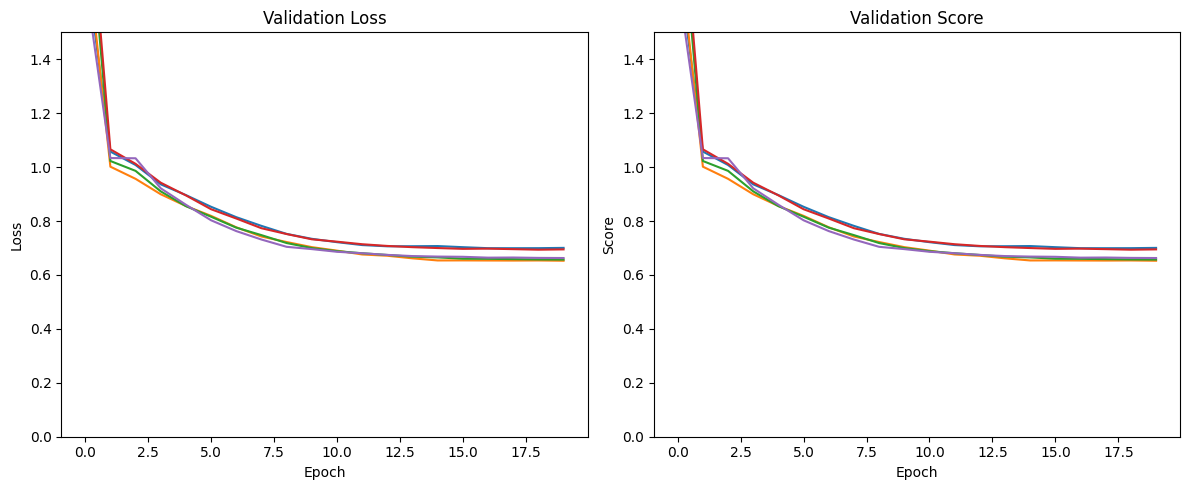

In [22]:
main()

# inference

In [23]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [24]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/tmp/ipykernel_65734/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)['model']


load ../proc/baseline/outputs/atmacup_18_resnet2/atmacup_18-models/resnet34d_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_resnet2/atmacup_18-models/resnet34d_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_resnet2/atmacup_18-models/resnet34d_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_resnet2/atmacup_18-models/resnet34d_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]